In [15]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
!pip install chemfp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
from collections import OrderedDict
from itertools import chain
from sklearn.utils import shuffle

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [4]:
from scipy.stats import norm
# Keras uses TensforFlow backend as default
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Concatenate
from keras.layers import Conv1D,UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

In [5]:
import tensorflow as tf

import keras
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
import keras.layers as layer
from keras import backend as K
from sklearn.model_selection import train_test_split

In [6]:
import pandas as pd
data = pd.read_csv('/content/smiles_prop_G150.txt', names = ['SMI', 'G150'], sep = ' ')

In [7]:
data = data.drop_duplicates()

In [8]:
def catg(x):
    if (x<-3):
        return 'a'
    elif (x>=-3 and x<-1):
        return 'b'  
    elif (x>=-1 and x<1):
        return 'c'  
    elif (x>=1 and x<3):
        return 'd'  
    elif (x>=3 and x<5):
        return 'e'  
    elif (x>=5 and x<7):
        return 'f'  
    elif (x>=7 and x<9):
        return 'g'  
    elif (x>=9 and x<11):
        return 'h'  
    elif (x>=11):
        return 'i'           

In [9]:
data['G150'] = data['G150'].apply(catg)

In [10]:
data.head(8)

,SMI,G150
0,Cl[Pt]23(Cl)(Cl)[n+]1c(cccc1)C(=[N+]2[N-]C(=[S...,h
1,[OH+]2[Ir+3](N1C(CCC1)C2=O)(P(C)(C)C)(P(C)(C)C...,e
2,[OH+]2[Ir+3]([n+]1c(cccc1)C2=O)(P(C)(C)C)(P(C)...,e
3,[OH+]1[Ir+3](NC(CO)C1=O)(P(C)(C)C)(P(C)(C)C)P(...,e
4,[OH+]1[Ir+3](NC(C(C)O)C1=O)(P(C)(C)C)(P(C)(C)C...,e
5,c1cc3[n+](cc1)[Cu]2(Br)([S+]=C([N-][N+]2=C3)N(...,g
6,P(=O)(CN1CC(C)CCC1)(c2ccccc2)c3ccccc3,e
7,c1cc3[n+](cc1)[Cu+]2(Br)[S+]=C([N-][N+]2=C3C)N...,g


In [11]:
unique_g150 = sorted(list(OrderedDict.fromkeys(chain.from_iterable(data['G150']))))
unique_g150

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

In [12]:
g150_to_int = dict((c, i) for i, c in enumerate(unique_g150))
g150_to_int

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8}

In [13]:
data.iloc[0]['SMI']

'Cl[Pt]23(Cl)(Cl)[n+]1c(cccc1)C(=[N+]2[N-]C(=[S+]3)N4CC5CCC(C4)CC5)C'

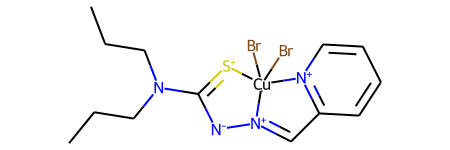

In [14]:
# Note that this will only work if you installed the rdkit package!
mol = Chem.MolFromSmiles(data.iloc[5]['SMI'])
mol

In [15]:
from rdkit import DataStructs
def smiles2fps(smls = "O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C"):
    fps = np.zeros((0,), dtype=np.int8)
    mol = Chem.MolFromSmiles(smls)
    # tfps = Chem.RDKFingerprint(mol)
    tfps = MACCSkeys.GenMACCSKeys(mol)
    DataStructs.ConvertToNumpyArray(tfps,fps)
    return fps   

## Converting SMILES string to numbers

In [16]:
# creating mapping for each char to integer, also mapping for the E (end) is manually inserted into the dictionaries.
unique_chars = sorted(list(OrderedDict.fromkeys(chain.from_iterable(data['SMI']))))
# maps each unique character as int
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))

In [17]:
# int to char dictionary
int_to_char = dict((i, c) for i, c in enumerate(unique_chars))

In [18]:
# add stop letter to dictionary  ---  Ф
char_to_int.update({"Ф" : len(char_to_int)})
int_to_char.update({len(int_to_char) : "Ф"})

In [19]:
# char_to_int

In [20]:
# int_to_char

In [21]:
# how many unique characters do we have?
mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)
print ("Size of the character to integer dictionary is: ", mapping_size)
print ("Size of the integer to character dictionary is: ", reverse_mapping_size)

Size of the character to integer dictionary is:  60
Size of the integer to character dictionary is:  60


In [22]:
embed = max([len(seq) for seq in data['SMI']])  # maximum length of SMILES string

In [23]:
embed

464

In [24]:
# Smiles to Vec
def smiles2vec(smiles  = "O=C(NCc1cc(OC)c(O)cc1)CCCC/C#C/C(C)C"):
    vec = char_to_int['Ф']*np.ones((1, 464), np.uint8)
    for j,c in enumerate(smiles):
        vec[0, j] = char_to_int[c]
    return vec

# Vec to Smiles  
def vec2smiles(vc):
    vl = vc[0].tolist()
    smle = ""
    for j,c in enumerate(vl):
        if int_to_char[c]=='Ф':
            break
        smle = smle + int_to_char[c]
    return smle  

##     
# data['FP'] =  data['SMI'].apply(smiles2vec)  # applying manual function to 
# x_data_ = data['FP'].to_numpy()
# y_data_ = data['G150'].to_numpy()

def generate_data(x_data_, y_data_, embed, unique_g150):
    # x_data and y_data
    x_data = np.zeros((len(x_data_),1, embed))  
    # y_data  = np.zeros((len(y_data_),1, 1))
    yOHE = np.zeros((len(data), 1, len(unique_g150)),dtype=np.int8)
    for i in range(len(x_data_)):
        x_data[i, :, :]=  x_data_[i]
        # y_data[i, :, :]=  y_data_[i] 

    # ydata   
    for ii, g150 in enumerate(data['G150']):
        yOHE[ii, :, g150_to_int[g150]]= 1   
    return x_data, yOHE #y_data    


# Generate the datasets
def gen_data(data, int_to_char, char_to_int, g150_to_int, unique_g150, embed):
    one_hot =  np.zeros((len(data), embed, len(char_to_int)),dtype=np.float32)
    yOHE = np.zeros((len(data), 1, len(unique_g150)),dtype=np.uint8)
    #XDATA
    for i, smile in enumerate(data['SMI']):
        #encode the chars
        for j,c in enumerate(smile):
            one_hot[i,j,char_to_int[c]] = 1
        #Encode endchar
        one_hot[i,len(smile):,char_to_int["Ф"]] = 1

    #YDATA
    for ii, g150 in enumerate(data['G150']):
        yOHE[ii, :, g150_to_int[g150]]= 1
    return np.swapaxes(one_hot, 1, 2), yOHE

In [26]:
# Xdata, Ydata  = generate_data(x_data_, y_data_, embed, unique_g150) # step=1...not working
Xdata, Ydata = gen_data(data, int_to_char, char_to_int, g150_to_int, unique_g150, embed)

x_min = Xdata.min(axis=(1, 2), keepdims=True)
x_max = Xdata.max(axis=(1, 2), keepdims=True)

Xdata   = (Xdata - x_min)/(x_max-x_min)
 
y_min = Ydata.min(axis=(1, 2), keepdims=True)
y_max = Ydata.max(axis=(1, 2), keepdims=True)

Ydata   = (Ydata - y_min)/(y_max-y_min)

# # Train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata,  test_size=0.30, random_state=42)

In [27]:
Xdata.shape, Ydata.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34398, 60, 464),
 (34398, 1, 9),
 (24078, 60, 464),
 (10320, 60, 464),
 (24078, 1, 9),
 (10320, 1, 9))

In [29]:
Ydata[0]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [105]:
h_size = 128
z_dims = 10
n_classes = 9
inp_dims  = X_train.shape[2]
steps  =  X_train.shape[1]
input_img =  keras.Input(shape=(steps , inp_dims))
input_cond = Input(shape=(1, n_classes))
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(z_dims, ))
    return mu + K.exp(log_var / 2) * eps



# Encoder
# traj_input =  Concatenate(axis=-1)([input_img, input_cond])
traj_input = layer.Conv1D(h_size, 3, activation = 'relu', padding = 'same')(input_img) ## 
traj_input = layer.UpSampling1D(size=2)(traj_input)
traj_input = layer.MaxPool1D(2, padding = 'same')(traj_input)
traj_input = layer.UpSampling1D(size=2)(traj_input)
traj_input = layer.Conv1D(h_size//8, 3, activation = 'relu', padding = 'same')(traj_input)
traj_input = layer.MaxPool1D(4, padding = 'same')(traj_input)
traj_input = layer.Flatten()(traj_input)
# trah_input = layer.Dropout(0.2)(traj_input)
# Sampling

z_mean = layer.Dense(z_dims, activation='tanh')(traj_input)
z_var_log = layer.Dense(z_dims, activation='linear')(traj_input)
z = Lambda(sample_z, output_shape=(z_dims,))([z_mean, z_var_log])
z= layer.Reshape((1, z_dims))(z)
# z_cond = Concatenate(axis=-1)([z, input_cond])

# Decoder
z_in = Input(shape=(1, z_dims,))
cond_in = Input(shape=(1, n_classes,))
dec_input = Concatenate(axis=-1)([z_in, cond_in])
z_traj_input = layer.Dense(256)(dec_input)
z_traj_input = layer.Reshape((4, 64))(z_traj_input)
z_traj_input = layer.Conv1D(h_size, 3, activation = 'relu', padding = 'same')(z_traj_input)
z_traj_input = layer.UpSampling1D(2)(z_traj_input) 
z_traj_input = layer.Conv1D(h_size, 2, activation = 'relu', padding = 'same')(z_traj_input)
z_traj_input = layer.UpSampling1D(2)(z_traj_input) 
z_traj_input = layer.Flatten()(z_traj_input)
# z_traj_input  =layer.RepeatVector(20)(z_traj_input)
# z_traj_input = layer.LSTM(units=16, return_sequences=True)(z_traj_input)
# z_traj_input = layer.Flatten()(z_traj_input)
z_traj_input = layer.Dense(inp_dims*steps, activation='sigmoid')(z_traj_input)
traj_hat = layer.Reshape((steps, inp_dims))(z_traj_input)

In [106]:
encoder = Model([input_img, input_cond], [z_mean, z_var_log, z, input_cond])
encoder.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 60, 464)]    0           []                               
                                                                                                  
 conv1d_24 (Conv1D)             (None, 60, 128)      178304      ['input_25[0][0]']               
                                                                                                  
 up_sampling1d_24 (UpSampling1D  (None, 120, 128)    0           ['conv1d_24[0][0]']              
 )                                                                                                
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 60, 128)     0           ['up_sampling1d_24[0][0]']

In [107]:
decoder =  Model([z_in, cond_in], traj_hat)
decoder.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 1, 10)]      0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1, 9)]       0           []                               
                                                                                                  
 concatenate_12 (Concatenate)   (None, 1, 19)        0           ['input_27[0][0]',               
                                                                  'input_28[0][0]']               
                                                                                                  
 dense_26 (Dense)               (None, 1, 256)       5120        ['concatenate_12[0][0]']  

In [108]:
output= decoder(encoder([[input_img, input_cond]])[2:])
output.shape

TensorShape([None, 60, 464])

In [109]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [112]:
cvae = Model([input_img, input_cond], output)
opt = tf.keras.optimizers.Adam(learning_rate=0.0023)
cvae.compile(optimizer=opt, loss=loss_func(z_mean, z_var_log), metrics=['accuracy'])

In [113]:
cvae.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 60, 464)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 1, 9)]       0           []                               
                                                                                                  
 model_15 (Functional)          [(None, 10),         194084      ['input_25[0][0]',               
                                 (None, 10),                      'input_26[0][0]']               
                                 (None, 1, 10),                                                   
                                 (None, 1, 9)]                                             

In [ ]:
from keras_visualizer import visualizer 
visualizer(model, format='png', view=True)


# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False,
# )

In [114]:
# train
history= cvae.fit([X_train[:1000,:,:], y_train[:1000,:,:]], X_train[:1000,:,:] ,
       shuffle=True,
       epochs=2,
       batch_size=1,
       verbose=1)

Epoch 1/2
1000/1000 [==============================] - 305s 303ms/step - loss: 4.0611 - accuracy: 0.7886
Epoch 2/2
1000/1000 [==============================] - 304s 304ms/step - loss: 3.3846 - accuracy: 0.7965


In [115]:
y_test[0].shape

(1, 9)

In [116]:
pred_class = y_train[0].reshape(1,1,9)
pred_noise = np.random.randn(1, z_dims).reshape(1,1,-1)
pred_out = decoder.predict([pred_noise, pred_class])

In [117]:
ind = np.unravel_index(np.argmax(pred_out, axis=1), pred_out.shape)

In [118]:
ind[2].shape

(1, 464)

In [119]:
s = vec2smiles(ind[2])

In [120]:
s

'OCCCc(Cn+]([O-([C2cC(ccc@@nC)Cc1C)F)(FCF)[O-C)c'

## Grid Plots

In [ ]:
import matplotlib.pyplot as plt


n=10
figsize=9
# display a n*n 2D manifold of digits
digit_size = 28
scale = 1.0
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

array_0_to_9 = np.arange(start = 0, stop = 10)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        num_class =   8 #np.random.choice(a = array_0_to_9)
        pred_class = np.array(8).reshape(1,1,-1)
        pred_noise = z_sample.reshape(1,1,-1)
        x_decoded = decoder.predict([pred_noise, pred_class])
        x_decoder_smile = vec2smiles(x_decoded)
        print(x_decoder_smile)
# plt.figure(figsize=(figsize, figsize))
# sample_range_x = np.round(grid_x, 1)
# sample_range_y = np.round(grid_y, 1)
# plt.xticks(pixel_range, sample_range_x)
# plt.yticks(pixel_range, sample_range_y)
# plt.xlabel("z[0]")
# plt.ylabel("z[1]")
# plt.imshow(figure, cmap="Greys_r")
# plt.show()




In [ ]:
x_decoded